<a href="https://colab.research.google.com/github/jan-1995/Inverted_Pendulum_LQR_Ctrl/blob/main/INVERTED_PENDULUM_LQR_CONTROL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT ALL LIBRARIES**

In [10]:
from math import cos, sin
import numpy as np
from random import random
import scipy.signal as signal
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Circle

**ALL PARAMETERS AND BUILD OF INVERTED PENDULUM ON CART**

K =  [[  -0.70710678 -100.48538883 -356.08511567 -113.12732395]]


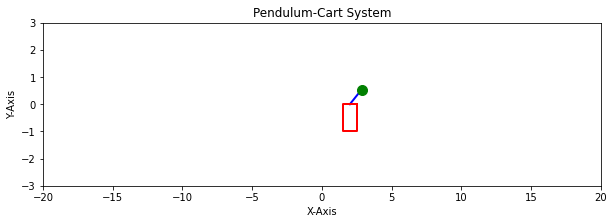

In [11]:
# Paramters
m = 0.1
M = 1
l = 1
g = 9.8
k = 1
R = 100
r = 0.02
f = 0

# Initial Conditions
x = 2
x_dot = 15
theta = 1
theta_dot = 6
states = np.array([x, x_dot, theta, theta_dot])

# Data Collection for Trajectories and Plots
x_data = []
x_dot_data = []
theta_data = []
theta_dot_data = []
f_data = []

# Simulation Parameters
dt = 0.1
Tfinal = 10
Ts = dt
Tsteps = Tfinal/Ts # number of frames
frames = int(Tsteps)

# A, B, Q, R, K matrix
A = np.array([[0,                 1,               0, 0],
              [0,  (-k*k)/(M*r*r*R),        (-m*g)/M, 0],
              [0,                 0,               0, 1],
              [0, (k*k)/(M*r*r*R*l), ((M+m)*g)/(M*l), 0]])

B = np.array([[0], [k/(M*r*R)], [0], [-k/(M*r*R*l)]])

Q = np.array([[1000000, 0, 0 , 0],
              [0, 1000000, 0, 0],
              [0, 0, 4000000, 0],
              [0, 0, 0, 4000000]])

R1 = [[2000000]]

P = np.matrix(linalg.solve_continuous_are(A, B, Q, R1))
K = np.matrix(linalg.inv(R1)*(B.T*P))
print('K = ',K)

eigVal, eigVec = linalg.eig(A-B*K)

#print(eigVal)

# Animation Paramaters
sT = np.sin(theta)
cT = np.cos(theta)
w = 1

rod_x = [x, x+l*sT]
rod_y = [0, l*cT]

fig = plt.figure(figsize = (10,3))
ax1 = plt.subplot(1,1,1)
ax1.set_xlim((-20,20))
ax1.set_ylim((-3,3))
ax1.set_xlabel('X-Axis')
ax1.set_ylabel('Y-Axis')
ax1.set_title('Pendulum-Cart System')

rod, = ax1.plot(rod_x, rod_y, 'b', lw = 2)
bob, = ax1.plot(x+l*sT, l*cT, 'g', marker = 'o', ms = 10)

p1 = [x+w/2, 0]
p2 = [x+w/2, -w]
p3 = [x-w/2, -w]
p4 = [x-w/2, 0]

cart_x = [p1[0], p2[0], p3[0], p4[0], p1[0]]
cart_y = [p1[1], p2[1], p3[1], p4[1], p1[1]]

cart, = ax1.plot(cart_x, cart_y, 'r', lw = 2)

x_data.append(states[0])
x_dot_data.append(states[1])
theta_data.append(states[2])
theta_dot_data.append(states[3])
f_data.append(f)

traj, = ax1.plot(x_data, 0, 'y:', lw = 1)
traj1, = ax1.plot(x_data+l*np.sin(theta_data), l*np.cos(theta_data), 'k:', lw = 1)

In [12]:
def rodPoints(x, l, theta):
  sT = np.sin(theta)
  cT = np.cos(theta)

  rod_x = [x, x+l*sT]
  rod_y = [0, l*cT]

  return [rod_x, rod_y]

def bobPoints(x, l, theta):
  sT = np.sin(theta)
  cT = np.cos(theta)

  bob_x, bob_y = x+l*sT, l*cT

  return [bob_x, bob_y]

def cartPoints(x):
  w = 1
  p1 = [x+w/2, 0]
  p2 = [x+w/2, -w]
  p3 = [x-w/2, -w]
  p4 = [x-w/2, 0]

  cart_x = [p1[0], p2[0], p3[0], p4[0], p1[0]]
  cart_y = [p1[1], p2[1], p3[1], p4[1], p1[1]]

  return [cart_x, cart_y]

In [13]:
def dyna_pencart(t,y,f):
  x = y[0]
  x_dot = y[1]
  theta = y[2]
  theta_dot = y[3]

  x_ddot = (k*f)/(M*R*r) - (k*k*x_dot)/(M*r*r*R) - (m*g*theta)/M
  theta_ddot = ((m+M)*g*theta)/(M*l) + (k*k*x_dot)/(M*r*r*R*l) - (k*f)/(M*r*R*l)

  return [y[1], x_ddot, y[3], theta_ddot]


def ctrl_lqr(y):
  f = -K[0,0]*y[0] -K[0,1]*y[1] -K[0,2]*y[2] -K[0,3]*y[3]

  return f  

In [14]:
def step(states, dt):
  x= states[0]
  x_dot = states[1]
  theta = states[2]
  theta_dot = states[3]

  f = ctrl_lqr(states)
  f_data.append(f)

  sol = solve_ivp(lambda t,y: dyna_pencart(t,y,f), [0, dt], [x, x_dot, theta, theta_dot], t_eval = np.linspace(0, dt, 100))
  states = sol.y[:,-1].T

  return states

In [15]:
def drawframe(i):
  global states
  states = step(states, dt)
  x = states[0]
  x_dot = states[1]
  theta = states[2]
  theta_dot = states[3]

  x_data.append(states[0])
  x_dot_data.append(states[1])
  theta_data.append(states[2])
  theta_dot_data.append(states[3])

  rod_x, rod_y = rodPoints(x, l, theta)
  bob_x, bob_y = bobPoints(x, l, theta)
  cart_x, cart_y = cartPoints(x)

  rod.set_data(rod_x, rod_y)
  bob.set_data(bob_x, bob_y)
  cart.set_data(cart_x, cart_y)
  traj.set_data(x_data,0)
  traj1.set_data(x_data+l*np.sin(theta_data), l*np.cos(theta_data))

  return rod, bob, cart, traj, traj1

In [16]:
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_title('Pendulum-Cart System')

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=frames, interval=100, blit=True)

In [17]:
from IPython.display import HTML
HTML(anim.to_html5_video())

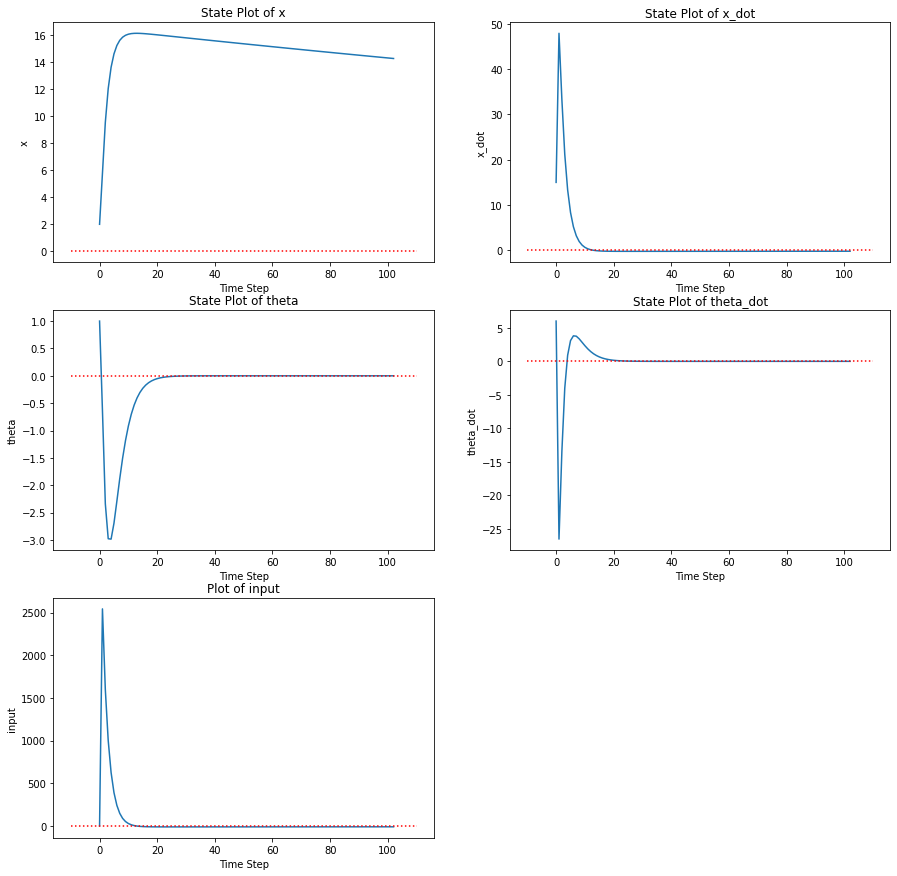

In [18]:
# Figure to plot the states against time step
a = [-10, 110]
b = [0, 0]
fig1 = plt.figure(figsize=(15,15))
ax2 = fig1.add_subplot(3, 2, 1)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('x')
ax2.set_title('State Plot of x')
x1 = ax2.plot(range(len(x_data)),x_data)
A = ax2.plot(a, b, 'r:')

ax3 = fig1.add_subplot(3, 2, 2)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('x_dot')
ax3.set_title('State Plot of x_dot')
x_dot1 = ax3.plot(range(len(x_dot_data)),x_dot_data)
A = ax3.plot(a, b, 'r:')

ax4 = fig1.add_subplot(3, 2, 3)
ax4.set_xlabel('Time Step')
ax4.set_ylabel('theta')
ax4.set_title('State Plot of theta')
theta1 = ax4.plot(range(len(theta_data)),theta_data)
A = ax4.plot(a, b, 'r:')

ax5 = fig1.add_subplot(3, 2, 4)
ax5.set_xlabel('Time Step')
ax5.set_ylabel('theta_dot')
ax5.set_title('State Plot of theta_dot')
theta_dot1 = ax5.plot(range(len(theta_dot_data)),theta_dot_data)
A = ax5.plot(a, b, 'r:')

ax6 = fig1.add_subplot(3, 2, 5)
ax6.set_xlabel('Time Step')
ax6.set_ylabel('input')
ax6.set_title('Plot of input')
f1 = ax6.plot(range(len(f_data)),f_data)
A = ax6.plot(a, b, 'r:')


# def quad_dyna1(t, y, F, T_phi, T_theta, T_psi):
#   pn = y[0]
#   pe = y[1]
#   pd = y[2]
#   u = y[3]
#   v = y[4]
#   w = y[5]
#   phi = y[6]
#   theta = y[7]
#   psi = y[8]
#   p = y[9]
#   q = y[10]
#   r = y[11]

#   # variables for sin, cos and tan functions
#   sPh = np.sin(phi)
#   cPh = np.cos(phi)
#   sT = np.sin(theta)
#   cT = np.cos(theta)
#   TT = np.tan(theta)
#   sPs = np.sin(psi)
#   cPs = np.cos(psi)

#   lin_v = np.array([u, v, w]).T # linear velocity(u,v,w) array
#   ang_v = np.array([p, q, r]).T # angular velocity(p,q,r) array
#   R1 = rot_mat_bod2veh(phi, theta, psi) # rotational matrix

#   # First equation
#   temp0 = np.matmul(R1,lin_v)
#   #pn_dot = temp0[0]
#   #pe_dot = temp0[1]
#   #pd_dot = temp0[2]
#   pn_dot = u
#   pe_dot = v
#   pd_dot = w

#   # Second equation
#   lin_ang_v = np.array([r*v-q*w, p*w-r*u, q*u-p*v]).T
#   #grav_vec = np.array([0, 0, g]).T
#   grav_vec = np.array([0, 0, 1*g]).T
#   f_mat = np.array([0, 0, -F/m]).T
  
#   temp1 = np.cross(ang_v, lin_v) + np.matmul(R1,grav_vec) + f_mat
#   u_dot = temp1[0]
#   v_dot = temp1[1]
#   w_dot = temp1[2]

#   # Third Equation
#   D = der_ang2rates(phi, theta)
#   temp2 = np.matmul(D,ang_v)
#   phi_dot = temp2[0]
#   theta_dot = temp2[1]
#   psi_dot = temp2[2]

#   # Forth Equation
#   p_dot = (Jy - Jz)/Jx*q*r + (1/Jx)*T_phi
#   q_dot = (Jx-Jz)/Jy * p*r + (1/Jy)*T_theta
#   r_dot = (Jx-Jy)/Jz * p *q + (1/Jz)*T_psi

#   return [pn_dot, pe_dot, pd_dot, u_dot, v_dot, w_dot, phi_dot, theta_dot, psi_dot, p_dot, q_dot, r_dot]